<a href="https://colab.research.google.com/github/francescodisalvo05/polito-machine-learning-for-IoT/blob/main/Labs/Lab_00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1 - Temperature Forecasting

In [ ]:
!wget https://raw.githubusercontent.com/francescodisalvo05/polito-machine-learning-for-IoT/main/Datasets/log_temp.csv

In [38]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import lfilter

sns.set_style('darkgrid')

In [ ]:
df = pd.read_csv('log_temp.csv', names=["date","hour","temperature","humidity"])
df.fillna("error",inplace=True)

# temperature column is like T=temp
# whereas humidity is like H=hum
# clean

df["temperature"] = df["temperature"].apply(lambda x : float(x.split("=")[1]) if not x == "error" else np.nan)
df["humidity"] = df["humidity"].apply(lambda x : float(x.split("=")[1]) if not x == "error" else np.nan)

## Check null values and anomalies

Text(0.5, 1.0, 'Humidity')

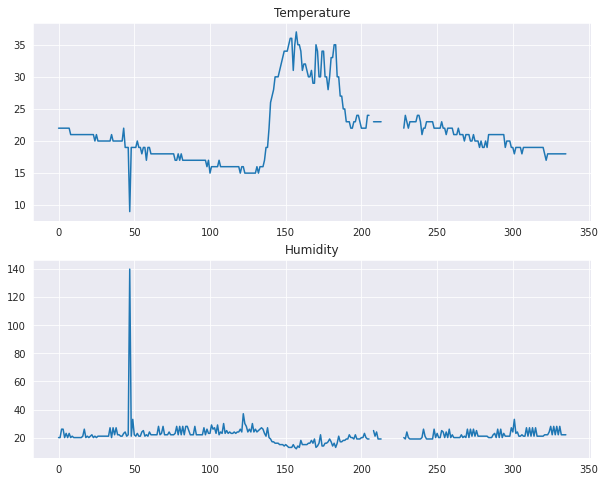

In [ ]:
fig, ax = plt.subplots(figsize=(10,8), nrows=2, ncols=1)

ax[0].plot(df.temperature)
ax[0].set_title("Temperature")

ax[1].plot(df.humidity)
ax[1].set_title("Humidity")

From this chart we can see that
* there is an anomaly around 50
* there are some (16) missing values around 220

## Handle anomaly

In [ ]:
# it is the one at index 47 -> force to NaN
df_new = df.copy()
df_new.iloc[47] = [df_new.iloc[47][0], df_new.iloc[47][1], np.nan, np.nan]

In [ ]:
df_new.iloc[47]

date            3/14/19
hour           23:53:41
temperature         NaN
humidity            NaN
Name: 47, dtype: object

## Handle missing values

In [ ]:
# interpolation through nearest neighbor
df_cleaned = df_new.interpolate('nearest')

Text(0.5, 1.0, 'Humidity')

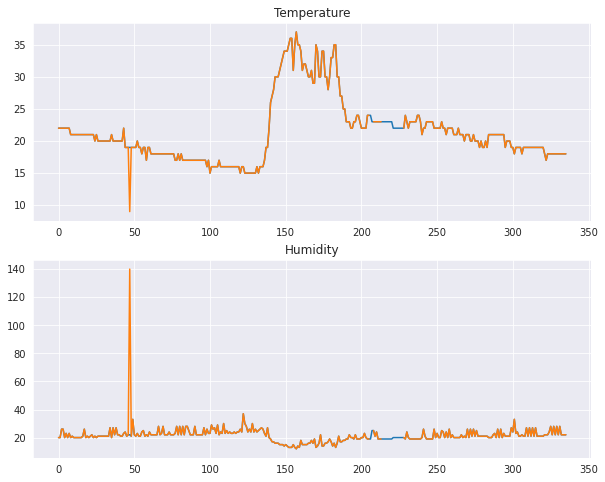

In [ ]:
fig, ax = plt.subplots(figsize=(10,8), nrows=2, ncols=1)

ax[0].plot(df_cleaned.temperature)
ax[0].plot(df.temperature)
ax[0].set_title("Temperature")

ax[1].plot(df_cleaned.humidity)
ax[1].plot(df.humidity)
ax[1].set_title("Humidity")

## Part 2 - Predictive Maintainance

Note : The dataset used in the lab was not available and I did not find the test dataset with the RUL (Remaining Useful Lifetime) feature. Therefoere I cannot make the prediction and I will just do the preprocessing step.

In [ ]:
!wget https://raw.githubusercontent.com/hankroark/Turbofan-Engine-Degradation/master/CMAPSSData/train_FD001.txt
# !wget https://raw.githubusercontent.com/hankroark/Turbofan-Engine-Degradation/master/CMAPSSData/test_FD001.txt

In [50]:
names = ["engine_no", "time_in_cycles", "operational_setting_1", "operational_setting_2", "operational_setting_3",
         "sensor_measurement_1", "sensor_measurement_2", "sensor_measurement_3", "sensor_measurement_4", "sensor_measurement_5",
         "sensor_measurement_6", "sensor_measurement_7", "sensor_measurement_8", "sensor_measurement_9", "sensor_measurement_10",
         "sensor_measurement_11", "sensor_measurement_12", "sensor_measurement_13", "sensor_measurement_14", "sensor_measurement_15",
         "sensor_measurement_16", "sensor_measurement_17", "sensor_measurement_18", "sensor_measurement_19", "sensor_measurement_20",
         "sensor_measurement_21", "sensor_measurement_22", "sensor_measurement_23",
         ]
df_train_nasa = pd.read_csv('train_FD001.txt', delimiter=' ', names=names)

In [51]:
# there is no RUL column
# names_test = names + ["RUL"]
# df_test_nasa = pd.read_csv('test_FD001.txt', delimiter=' ', header=None)

In [52]:
df_train_nasa.head()

,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_10,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,sensor_measurement_22,sensor_measurement_23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


## Handle Null Values

In [53]:
df_train_nasa.isnull().sum()

engine_no                    0
time_in_cycles               0
operational_setting_1        0
operational_setting_2        0
operational_setting_3        0
sensor_measurement_1         0
sensor_measurement_2         0
sensor_measurement_3         0
sensor_measurement_4         0
sensor_measurement_5         0
sensor_measurement_6         0
sensor_measurement_7         0
sensor_measurement_8         0
sensor_measurement_9         0
sensor_measurement_10        0
sensor_measurement_11        0
sensor_measurement_12        0
sensor_measurement_13        0
sensor_measurement_14        0
sensor_measurement_15        0
sensor_measurement_16        0
sensor_measurement_17        0
sensor_measurement_18        0
sensor_measurement_19        0
sensor_measurement_20        0
sensor_measurement_21        0
sensor_measurement_22    20631
sensor_measurement_23    20631
dtype: int64

In [54]:
df_train_nasa.drop(columns=["sensor_measurement_22", "sensor_measurement_23"], inplace=True)

## Visualize sensor data

In [55]:
features_to_plot = df_train_nasa.columns[2:]
df_grouped = df_train_nasa.groupby('engine_no').get_group(1)[features_to_plot]

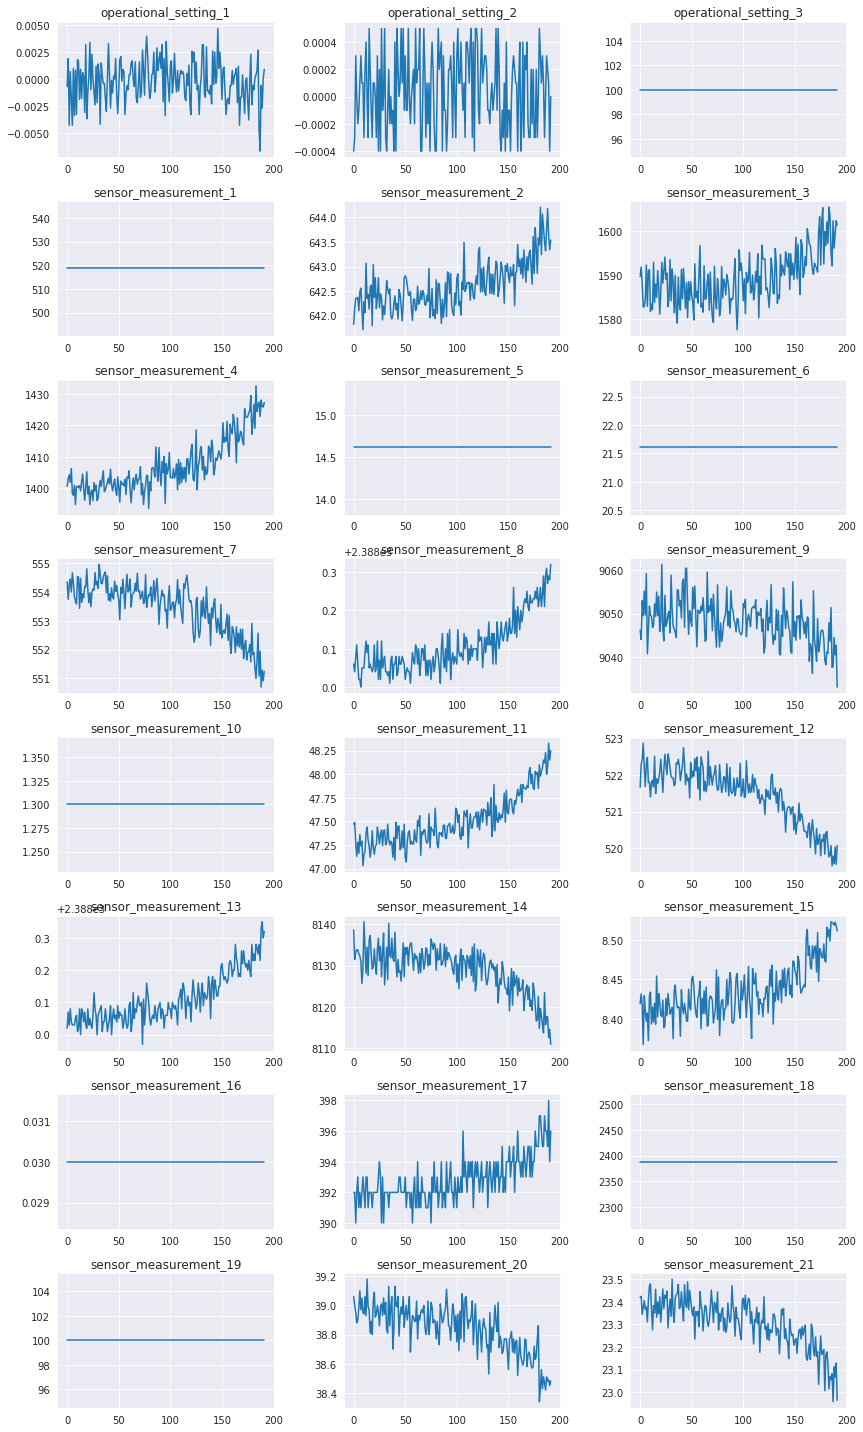

In [56]:
plt.figure(figsize=(12,20))

for i,feature in enumerate(features_to_plot):
  
  plt.subplot(8,3,i + 1)

  plt.plot(df_grouped[feature])
  plt.title(feature)

plt.tight_layout()

Note : sensors with constant values can be discarded because they cannot provide any particular information related to a potenital issue

In [62]:
useless_features = ['operational_setting_3','sensor_measurement_1',
                    'sensor_measurement_5', 'sensor_measurement_6',
                    'sensor_measurement_10', 'sensor_measurement_16',
                    'sensor_measurement_18', 'sensor_measurement_19']

df_train_nasa.drop(columns=useless_features, inplace=True)

## Parametric Moving Average Filter

In [63]:
# credits to the instructor

window_size = 5
weights = (1. / window_size) * np.ones(window_size)
b = (1 / window_size) * np.ones(window_size);
a = np.array([1]);
zi = scipy.signal.lfilter_zi(b, a)

for _, group in df_train_nasa.groupby('engine_no'):
    
    indexes = group.index
    
    for column in df_train_nasa.columns[2:]:

        x = df_train_nasa[column][indexes]
        x_filt, _ = lfilter(b, a, x, zi=zi*x.iloc[0])
        
        for i, index in enumerate(indexes):
            df_train_nasa.at[index, column] = x_filt[i]
            
features = df_train_nasa.columns[2:]
df_train_nasa_grouped = df_train_nasa.groupby('engine_no').get_group(1)[features]

In [64]:
len(features)

16

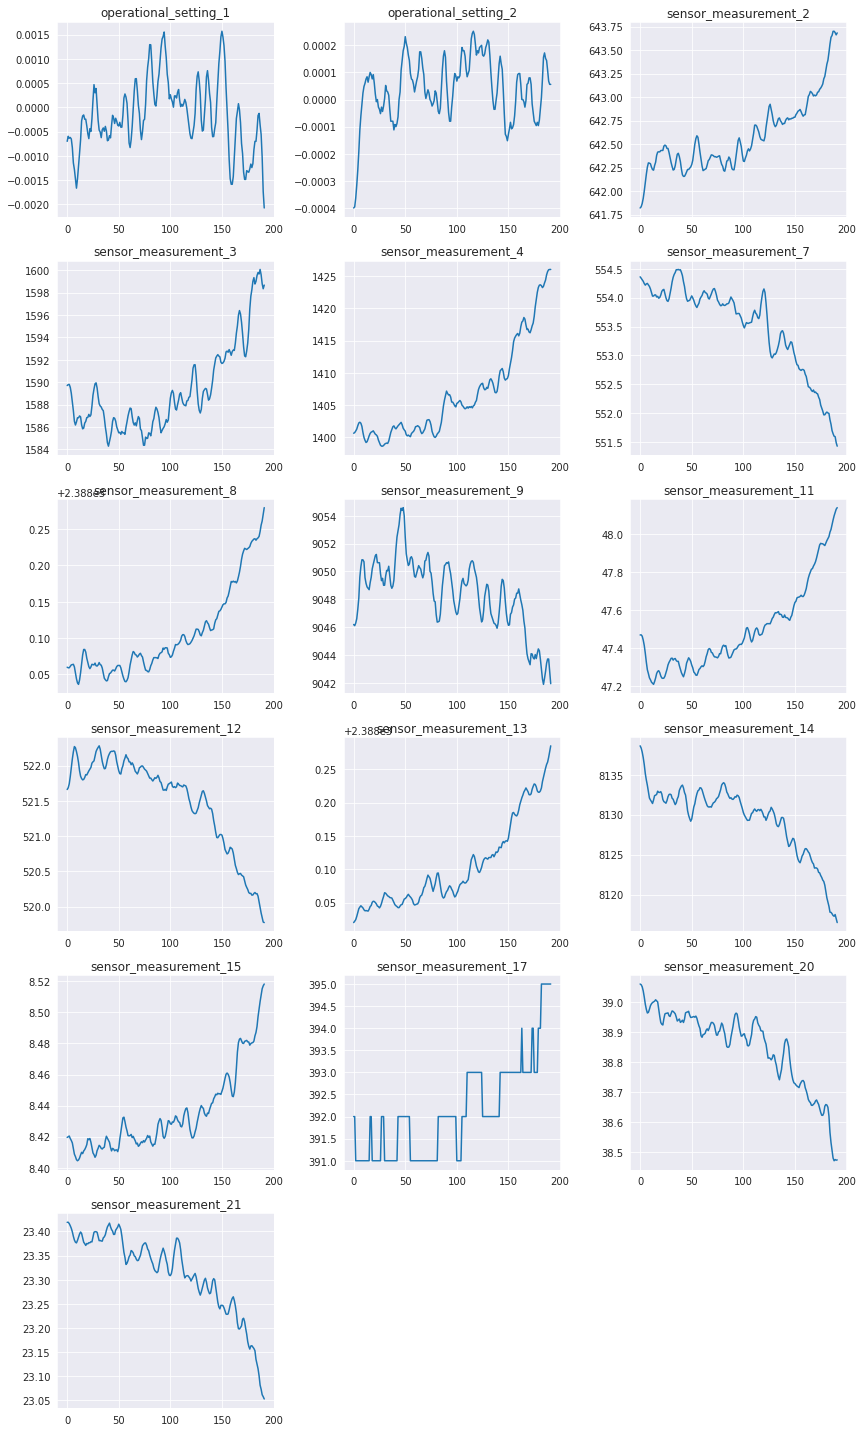

In [65]:
plt.figure(figsize=(12,20))

for i,feature in enumerate(features):
  
  plt.subplot(6,3,i + 1)

  plt.plot(df_train_nasa_grouped[feature])
  plt.title(feature)

plt.tight_layout()

## Normalization

In [66]:
# collect statistics
t_mean = df_train_nasa.mean(axis=0)
t_std = df_train_nasa.std(axis=0)

# normalize : (x - mean) / std
for _, group in df_train_nasa.groupby('engine_no'):
    indexes = group.index
    for column in df_train_nasa.columns[2:]:
        x = df_train_nasa[column][indexes]
        x_norm = (x - t_mean[column]) / (t_std[column])

        for index in indexes:
            df_train_nasa.at[index, column] = x_norm[index]

features = df_train_nasa.columns[2:]
df_train_nasa_grouped = df_train_nasa.groupby('engine_no').get_group(1)[features]

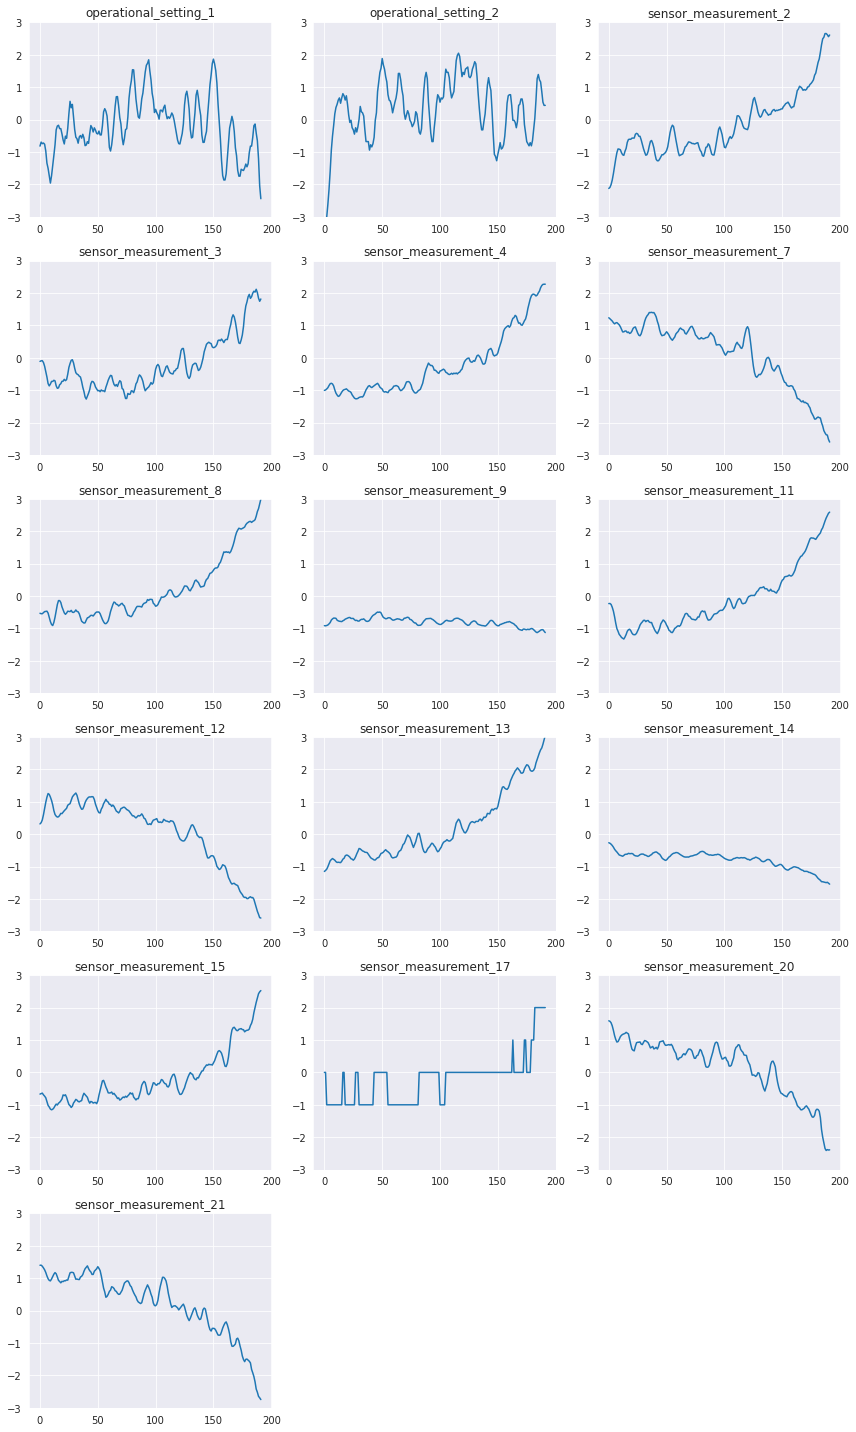

In [71]:
plt.figure(figsize=(12,20))

for i,feature in enumerate(features):
  
  plt.subplot(6,3,i + 1)

  plt.plot(df_train_nasa_grouped[feature])
  plt.ylim(-3,3)
  plt.title(feature)

plt.tight_layout()